In [1]:
import os
import keras
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.layers import BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import zipfile
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras import models, layers, callbacks
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from google.colab import drive
import matplotlib.pyplot as plt
from keras.applications import VGG16

In [ ]:
#mount drive if necessary
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# download dataset from kaggle
# upload .json of kaggle
! mkdir -p ~/.kaggle;
! cp kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:05<00:00, 274MB/s]
100% 1.33G/1.33G [00:05<00:00, 247MB/s]


In [ ]:
#unzip the files
!unzip celeba-dataset.zip

In [4]:
# Image Data Generator so we dont need to load all images the same time

# Define paths, change accordingly
image_directory = '/content/img_align_celeba/img_align_celeba'
csv_file = '/content/list_attr_celeba.csv'

# Load CSV file
df = pd.read_csv(csv_file)
df.replace(-1, 0, inplace=True)
print(df.columns)

# Split data into training, validation, and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Create separate ImageDataGenerator instances for training, validation, and testing sets
train_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values to [0, 1]
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for testing/validation data
val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for testing/validation data

# Flow images in batches from the directories for training, validation, and testing sets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_directory,
    x_col='image_id',  # column containing image filenames
    y_col=train_df.columns[1:],  # columns containing attribute labels
    target_size=(299, 299),  # Resize images
    batch_size=128,
    class_mode='raw'  # use 'raw' for multilabel classification
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_directory,
    x_col='image_id',
    y_col=val_df.columns[1:],
    target_size=(299, 299),
    batch_size=128,
    class_mode='raw'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_directory,
    x_col='image_id',
    y_col=test_df.columns[1:],
    target_size=(299, 299),
    batch_size=1,
    class_mode='raw',
    shuffle=False
)

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')
Found 145871 validated image filenames.
Found 16208 validated image filenames.
Found 40520 validated image filenames.


In [ ]:
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [5]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint

# Create InceptionV3 model with ImageNet weights
inception_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

# Freeze the layers in the InceptionV3 model
for layer in inception_model.layers:
    layer.trainable = False

# Add your custom layers on top of InceptionV3
model = models.Sequential()
model.add(inception_model)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(40, activation='sigmoid'))  # Assuming 40 output classes for multilabel classification

# Compile the model with binary_crossentropy since it's binary classification per column
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

# Display model summary
model.summary()

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define a checkpoint callback
checkpoint = ModelCheckpoint(filepath='/content/model_epochInception_{epoch:02d}.h5', save_freq='epoch')

# Note: Ensure that your data generators (train_generator and val_generator) produce images of size 299x299 to match InceptionV3's expected input size.

# Train the model with early stopping
history = model.fit(train_generator,
                    epochs=10,
                    steps_per_epoch=len(train_generator),
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[early_stopping, checkpoint])

# Evaluate model on test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

# Predictions
predictions = model.predict(test_generator, steps=len(test_generator))

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 64)                8388672   
                                                                 
 dense_1 (Dense)             (None, 40)                2600      
                                                                 
Total params: 30194056 (115.18 MB)
Trainable params: 8391272 (32.01 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
Epoch 1/10
1140/1140 [==============================] - ETA: 0s - loss: 0.4

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1140/1140 [==============================] - 648s 551ms/step - loss: 0.4645 - binary_accuracy: 0.7958 - val_loss: 0.4013 - val_binary_accuracy: 0.8275
Epoch 2/10
1140/1140 [==============================] - 609s 534ms/step - loss: 0.3870 - binary_accuracy: 0.8339 - val_loss: 0.3757 - val_binary_accuracy: 0.8390
Epoch 3/10
1140/1140 [==============================] - 632s 554ms/step - loss: 0.3656 - binary_accuracy: 0.8417 - val_loss: 0.3594 - val_binary_accuracy: 0.8430
Epoch 4/10
1140/1140 [==============================] - 609s 534ms/step - loss: 0.3545 - binary_accuracy: 0.8437 - val_loss: 0.3529 - val_binary_accuracy: 0.8445
Epoch 5/10
1140/1140 [==============================] - 609s 534ms/step - loss: 0.3496 - binary_accuracy: 0.8443 - val_loss: 0.3497 - val_binary_accuracy: 0.8445
Epoch 6/10
1140/1140 [==============================] - 610s 535ms/step - loss: 0.3468 - binary_accuracy: 0.8449 - val_loss: 0.3485 - val_binary_accuracy: 0.8455
Epoch 7/10
1140/1140 [=================

KeyboardInterrupt: 

In [6]:
# Load model after training
model = load_model('model_epochInception_07.h5') #change path accordingly (using drive is faster than uploading to collab)

# Make predictions
filenames = test_generator.filenames
predictions = model.predict(test_generator, steps=len(test_generator))
print("Predictions:", predictions)

40520/40520 [==============================] - 519s 13ms/step
Predictions: [[0.3502861  0.05618061 0.19317827 ... 0.03962635 0.23686543 0.5843448 ]
 [0.00696664 0.28282893 0.6286037  ... 0.13374192 0.00472506 0.8364011 ]
 [0.25734505 0.06730417 0.22611447 ... 0.04506715 0.16860919 0.6158745 ]
 ...
 [0.12099276 0.09737139 0.3069283  ... 0.05880643 0.07695968 0.6784381 ]
 [0.24062558 0.0697909  0.23324174 ... 0.04625152 0.15688033 0.6221465 ]
 [0.28074712 0.06412151 0.21686852 ... 0.04353536 0.18529245 0.607466  ]]


In [7]:
# check if len matches
len(predictions)

40520

In [8]:
# print the classification report for all the features
true_labels = test_df.iloc[:, 1:]
predicted_labels = np.where(predictions > 0.5, 1, 0)

report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4471
           1       0.57      0.36      0.44     10822
           2       0.74      0.75      0.74     20702
           3       0.00      0.00      0.00      8378
           4       0.00      0.00      0.00       909
           5       0.00      0.00      0.00      6257
           6       0.26      0.00      0.01      9793
           7       0.00      0.00      0.00      9565
           8       0.00      0.00      0.00      9649
           9       0.62      0.02      0.04      6023
          10       0.00      0.00      0.00      1953
          11       0.00      0.00      0.00      8465
          12       0.00      0.00      0.00      5775
          13       0.00      0.00      0.00      2331
          14       0.00      0.00      0.00      1895
          15       0.00      0.00      0.00      2588
          16       0.00      0.00      0.00      2536
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
# Calculate the overall accuracy as the mean of these per-sample accuracies

accuracies_per_sample = (predicted_labels == true_labels).sum(axis=1) / 40
overall_accuracy = accuracies_per_sample.mean()
print(f"Overall accuracy of mode-based prediction: {overall_accuracy:.4f}")

Overall accuracy of mode-based prediction: 0.8431


In [10]:
accuracy_by_feature = {}
# Calculate accuracy for each feature separately
for feature in true_labels.columns:
    report = classification_report(true_labels[feature], predicted_labels[:, true_labels.columns.get_loc(feature)], output_dict=True)
    accuracy_by_feature[feature] = report['accuracy']

# Print accuracy for each feature
for feature, accuracy in accuracy_by_feature.items():
    print(f"Accuracy for '{feature}': {accuracy}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Accuracy for '5_o_Clock_Shadow': 0.8896594274432379
Accuracy for 'Arched_Eyebrows': 0.7572803553800592
Accuracy for 'Attractive': 0.7328726554787759
Accuracy for 'Bags_Under_Eyes': 0.7932379072063178
Accuracy for 'Bald': 0.9775666337611056
Accuracy for 'Bangs': 0.8455824284304048
Accuracy for 'Big_Lips': 0.7566140177690029
Accuracy for 'Big_Nose': 0.7639437314906219
Accuracy for 'Black_Hair': 0.7618706811451135
Accuracy for 'Blond_Hair': 0.8526406712734452
Accuracy for 'Blurry': 0.9518015794669299
Accuracy for 'Brown_Hair': 0.7909180651530109
Accuracy for 'Bushy_Eyebrows': 0.8574777887462981
Accuracy for 'Chubby': 0.9424728529121421
Accuracy for 'Double_Chin': 0.9532329713721619
Accuracy for 'Eyeglasses': 0.9361303060217177
Accuracy for 'Goatee': 0.9374136229022705
Accuracy for 'Gray_Hair': 0.9576505429417571
Accuracy for 'Heavy_Makeup': 0.8776406712734452
Accuracy for 'High_Cheekbones': 0.636080947680158
Accuracy for 'Male': 0.9380059230009872
Accuracy for 'Mouth_Slightly_Open': 0.549

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

093242.jpg


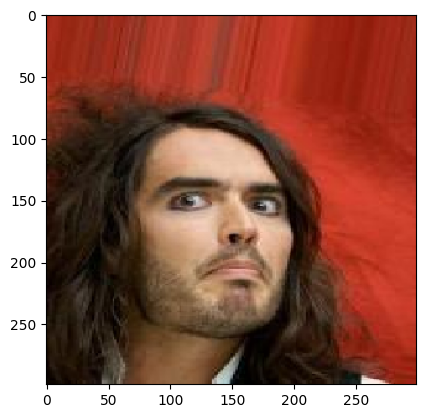

5_o_Clock_Shadow       0
Arched_Eyebrows        0
Attractive             0
Bags_Under_Eyes        0
Bald                   0
Bangs                  0
Big_Lips               0
Big_Nose               0
Black_Hair             0
Blond_Hair             0
Blurry                 0
Brown_Hair             0
Bushy_Eyebrows         0
Chubby                 0
Double_Chin            0
Eyeglasses             0
Goatee                 0
Gray_Hair              0
Heavy_Makeup           0
High_Cheekbones        0
Male                   1
Mouth_Slightly_Open    0
Mustache               0
Narrow_Eyes            0
No_Beard               0
Oval_Face              0
Pale_Skin              0
Pointy_Nose            0
Receding_Hairline      0
Rosy_Cheeks            0
Sideburns              0
Smiling                0
Straight_Hair          0
Wavy_Hair              0
Wearing_Earrings       0
Wearing_Hat            0
Wearing_Lipstick       0
Wearing_Necklace       0
Wearing_Necktie        0
Young                  1


5_o_Clock_Shadow       0
Arched_Eyebrows        0
Attractive             0
Bags_Under_Eyes        0
Bald                   0
Bangs                  0
Big_Lips               0
Big_Nose               0
Black_Hair             1
Blond_Hair             0
Blurry                 0
Brown_Hair             0
Bushy_Eyebrows         1
Chubby                 0
Double_Chin            0
Eyeglasses             0
Goatee                 0
Gray_Hair              0
Heavy_Makeup           0
High_Cheekbones        0
Male                   1
Mouth_Slightly_Open    0
Mustache               0
Narrow_Eyes            0
No_Beard               0
Oval_Face              0
Pale_Skin              0
Pointy_Nose            0
Receding_Hairline      0
Rosy_Cheeks            0
Sideburns              1
Smiling                0
Straight_Hair          0
Wavy_Hair              1
Wearing_Earrings       0
Wearing_Hat            0
Wearing_Lipstick       0
Wearing_Necklace       0
Wearing_Necktie        0
Young                  1


In [11]:
# print the image
image = test_generator.next()[0][0]
print(test_generator.filenames[0])
plt.imshow(image)
plt.show()

# rename columns
column_names = ['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young']

# use this to compare true labels vs predicted labels for a specific image (displayed above)
connections = pd.DataFrame(predicted_labels,columns=column_names[1:])
pd.set_option("display.max_columns",None)
display(connections.iloc[0]) #change indexes for diferent images

connections = pd.DataFrame(true_labels,columns=column_names[1:])
pd.set_option("display.max_columns",None) #change indexes for diferent images
display(connections.iloc[0])

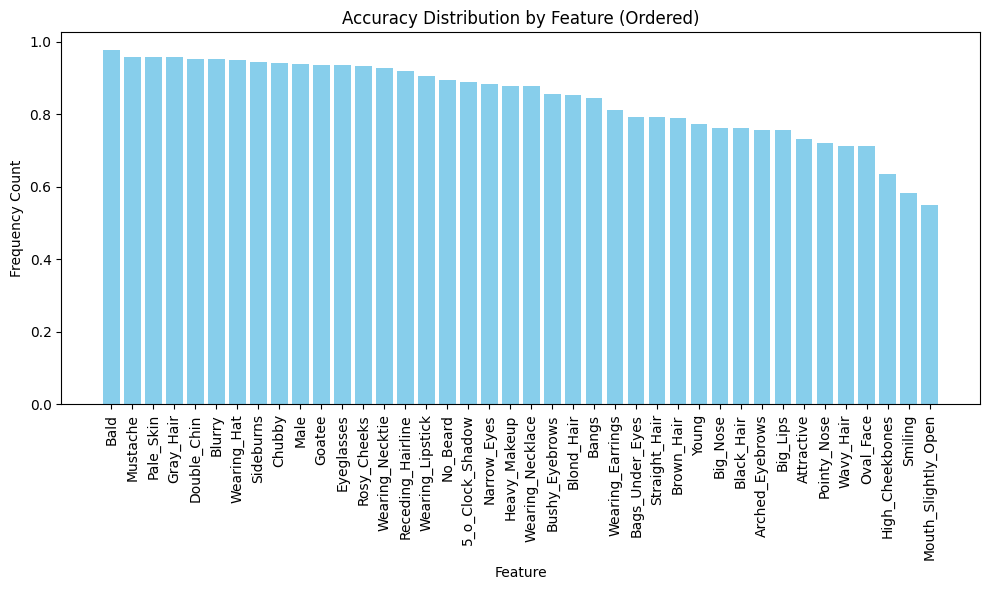

In [12]:
# Plot Accuracy histogram per feature

# Convert accuracy_by_feature dictionary to lists for plotting
features = list(accuracy_by_feature.keys())
accuracies = list(accuracy_by_feature.values())

# Sort features and accuracies by frequency count in descending order
sorted_indices = sorted(range(len(accuracies)), key=lambda k: accuracies[k], reverse=True)
sorted_features = [features[i] for i in sorted_indices]
sorted_accuracies = [accuracies[i] for i in sorted_indices]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_accuracies, color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Frequency Count')
plt.title('Accuracy Distribution by Feature (Ordered)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

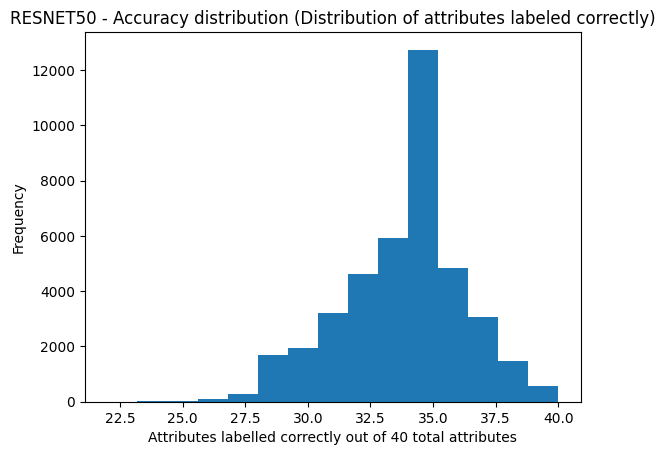

In [13]:
# Plot histogram of Attributes labelled correctly out of the 40

lr_correct_predictions = (true_labels == predicted_labels)
lr_samples_all_features_correct = np.sum(lr_correct_predictions.all(axis=1))

lr_correct_prediction_rows = pd.DataFrame(lr_correct_predictions.sum(axis=1))
lr_correct_prediction_rows.plot.hist(bins=15)
plt.title("RESNET50 - Accuracy distribution (Distribution of attributes labeled correctly)")
plt.legend().remove()
plt.xlabel("Attributes labelled correctly out of 40 total attributes");